<a href="https://colab.research.google.com/github/Zypperman/DBTT_G1_GRP3/blob/prelim_EDA/Notebooks/Usecase_0_0_V1(EDA).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EDA + Code adaptation

Data obtained from [Kaggle](https://www.kaggle.com/datasets/ajay1735/hmeq-data) -- Home Equity (HMEQ) dataset for Loan Defaulter Prediction.

----
##### Content obtained from link above
----
## About Dataset
**Context**  
The consumer credit department of a bank wants to automate the decision-making process for approval of home equity lines of credit. To do this, they will follow the recommendations of the Equal Credit Opportunity Act to create an empirically derived and statistically sound credit scoring model. The model will be based on data collected from recent applicants granted credit through the current process of loan underwriting. The model will be built from predictive modeling tools, but the created model must be sufficiently interpretable to provide a reason for any adverse actions (rejections).

**Content**  
The Home Equity dataset (HMEQ) contains baseline and loan performance information for 5,960 recent home equity loans. The target (BAD) is a binary variable indicating whether an applicant eventually defaulted or was seriously delinquent. This adverse outcome occurred in 1,189 cases (20%). For each applicant, 12 input variables were recorded.

The data set HMEQ reports characteristics and delinquency information for 5,960 home equity loans. A home equity loan is a loan where the obligor uses the equity of his or her home as the underlying collateral. The data set has the following characteristics:

**Data Dictionary**

| Variable | Description | Data Type |
|------------|------------|------------|
| BAD        | 1 = applicant defaulted on loan or seriously delinquent;<br> 0 = applicant paid loan | Binary Nominal (Target Variable)  |
| LOAN       | Amount of the loan request                                                                      | Ratio-Scaled Numeric      |
| MORTDUE    | Amount due on existing mortgage                                                                 | Ratio-Scaled Numeric      |
| VALUE      | Value of current property                                                                      | Ratio-Scaled Numeric      |
| REASON     | DebtCon = debt consolidation; <br>HomeImp = home improvement                                        | Nominal                   |
| JOB        | Occupational categories                                                                         | Nominal                   |
| YOJ        | Years at present job                                                                           | Numeric                   |
| DEROG      | Number of major derogatory reports                                                              | Numeric                   |
| DELINQ     | Number of delinquent credit lines                                                               | Numeric                   |
| CLAGE      | Age of oldest credit line in months                                                             | Numeric                   |
| NINQ       | Number of recent credit inquiries                                                               | Numeric                   |
| CLNO       | Number of credit lines                                                                          | Numeric                   |
| DEBTINC    | Debt-to-income ratio| Ratio-Scaled Numeric      |

----

## Translations and Assumptions

For the Krungsri Katalyst Analytic Dashboard, we make the following assumptions:  
- The bank already has a data lake and approximations of the data used in this analysis, either obtained from the loan applications, or compiled from information it already has about each applicant based on existing accounts and lines of credit.
- The data required for this model will be updated at frequent intervals, and larger volumes will be used for training in order to provide more robust predictions. For this, a data-pipeline needs to first be built by data engineers.
- For the future incorporation of time-series data modelled after the economic state, there also needs to be a robust data-pipeline of both leading and lagging economic indicators provided. This will be supplemented by economists and related personnel by the bank who can make quantitative predictions and provide relevant statistics that are outside the scope of our expertise as consultants.





In [12]:
!pip install kagglehub
!pip install kagglehub[pandas-datasets]
!pip install scikit-learn

In [20]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import *
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.naive_bayes import GaussianNB
import statsmodels.api as sm
from scipy.stats import probplot
from sklearn import metrics
from sklearn import preprocessing
from sklearn import utils
from sklearn.metrics import mean_absolute_error
from statistics import mean, stdev
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import KFold, cross_val_score, cross_validate, StratifiedKFold
from sklearn.svm import SVC
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest

In [16]:
from genericpath import exists
# kaggle api key, please use your own to download the data
KAGGLE_USERNAME = 'zypperman'
KAGGLE_KEY = '084281dba0d0e6614a17ee1d7284235d'
DATA_FILEPATH = './kaggle/working/'

import kagglehub
from kagglehub import KaggleDatasetAdapter
import os

file_path =  'hmeq.csv' # referring to filepath in data source

# Set the Kaggle API credentials
os.environ['KAGGLE_USERNAME'] = KAGGLE_USERNAME
os.environ['KAGGLE_KEY'] = KAGGLE_KEY

# Load the latest version
data = kagglehub.dataset_load(
  KaggleDatasetAdapter.PANDAS,
  "ajay1735/hmeq-data",
  file_path,
)
# save raw data locally
os.makedirs(DATA_FILEPATH,exist_ok=True)
data.to_csv(DATA_FILEPATH+'hmeq.csv')

First 5 records:
    BAD  LOAN  MORTDUE     VALUE   REASON     JOB   YOJ  DEROG  DELINQ  \
0    1  1100  25860.0   39025.0  HomeImp   Other  10.5    0.0     0.0   
1    1  1300  70053.0   68400.0  HomeImp   Other   7.0    0.0     2.0   
2    1  1500  13500.0   16700.0  HomeImp   Other   4.0    0.0     0.0   
3    1  1500      NaN       NaN      NaN     NaN   NaN    NaN     NaN   
4    0  1700  97800.0  112000.0  HomeImp  Office   3.0    0.0     0.0   

        CLAGE  NINQ  CLNO  DEBTINC  
0   94.366667   1.0   9.0      NaN  
1  121.833333   0.0  14.0      NaN  
2  149.466667   1.0  10.0      NaN  
3         NaN   NaN   NaN      NaN  
4   93.333333   0.0  14.0      NaN  


## Intro remarks
- dataset seems to be on US clients, given the policy mentioned for where this data was obtained from (Equal Credit Opportunity Act)

## Basic Data exploration

First, we will assess the nature of the data we are dealing with.

In [18]:
print("sample of 5 records:")
data.sample(n=5).head()

sample of 5 records:


,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
5312,0,29800,225481.0,290762.0,DebtCon,ProfExe,13.0,0.0,1.0,239.321631,1.0,26.0,24.777985
1892,0,12500,55228.0,66569.0,DebtCon,Mgr,3.0,0.0,0.0,198.815167,1.0,17.0,27.996873
1917,0,12600,100590.0,138649.0,HomeImp,ProfExe,14.0,0.0,0.0,138.164705,4.0,22.0,34.598727
4523,0,23600,69846.0,189234.0,NaN,Other,11.0,0.0,0.0,357.805062,0.0,17.0,30.564280
2295,0,13900,48110.0,63601.0,DebtCon,ProfExe,5.0,0.0,0.0,153.735399,1.0,12.0,29.964687


Next, we will assess 3 elements to the data:
1. the number of rows there are
2. the specific name, data-type and number of null values we are dealing with
3. some basic statistics describing the data
  
These can be obtained using some simple methods.

In [19]:
print(f"The Data has {data.shape[0]} rows and {data.shape[1]} columns.")
print("-"*35,"DATA INFO","-"*35,'\n')
print(data.info)
print("-"*35,"BASIC STATS","-"*35,'\n')
print(data.describe())

The Data has 5960 rows and 13 columns.
----------------------------------- DATA INFO ----------------------------------- 

<bound method DataFrame.info of       BAD   LOAN  MORTDUE     VALUE   REASON     JOB   YOJ  DEROG  DELINQ  \
0       1   1100  25860.0   39025.0  HomeImp   Other  10.5    0.0     0.0   
1       1   1300  70053.0   68400.0  HomeImp   Other   7.0    0.0     2.0   
2       1   1500  13500.0   16700.0  HomeImp   Other   4.0    0.0     0.0   
3       1   1500      NaN       NaN      NaN     NaN   NaN    NaN     NaN   
4       0   1700  97800.0  112000.0  HomeImp  Office   3.0    0.0     0.0   
...   ...    ...      ...       ...      ...     ...   ...    ...     ...   
5955    0  88900  57264.0   90185.0  DebtCon   Other  16.0    0.0     0.0   
5956    0  89000  54576.0   92937.0  DebtCon   Other  16.0    0.0     0.0   
5957    0  89200  54045.0   92924.0  DebtCon   Other  15.0    0.0     0.0   
5958    0  89800  50370.0   91861.0  DebtCon   Other  14.0    0.0     0.0  

# Handling outliers , missing values and visualising data


We initialize the background for our visualisations:

In [21]:
sns.set(style="whitegrid")
# plt.style.use('white')
plt.rcParams.update({"grid.linewidth":0.5, "grid.alpha":0.5})
colormap = sns.diverging_palette(220, 10, as_cmap=True)

Visualising missing rows in our data:

The columns with missing values are: "MORTDUE", "VALUE", "REASON", "JOB", "YOJ", "DEROG", "DELINQ", "CLAGE", "NINQ", "CLNO", "DEBTINC"

Missing Data:

         incomplete_rows  percentage_incomplete
MORTDUE              518               8.691275
VALUE                112               1.879195
REASON               252               4.228188
JOB                  279               4.681208
YOJ                  515               8.640940
DEROG                708              11.879195
DELINQ               580               9.731544
CLAGE                308               5.167785
NINQ                 510               8.557047
CLNO                 222               3.724832
DEBTINC             1267              21.258389

Total number of missing cells: 5271, and 6.803% of the data is missing.


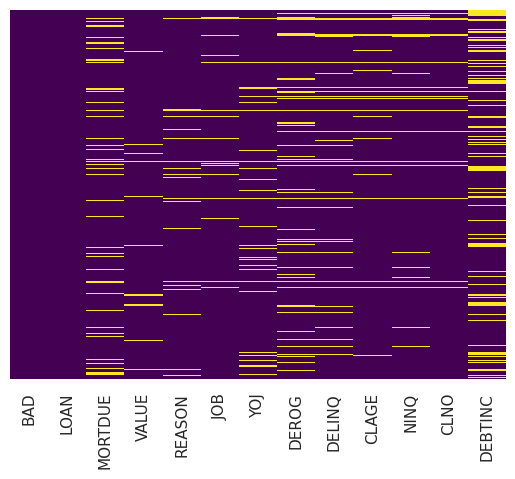

In [26]:
sns.heatmap(data.isnull(),cbar=False,yticklabels=False,cmap = 'viridis')

has_null = round(data.count() / data.shape[0],2) != 1 #condition assigned to variable
dataset_empty_columns = data.columns[has_null]

# get rows with empty datasets
dataset_empty_row_freq = pd.DataFrame([])
dataset_empty_row_freq['incomplete_rows'] = data.shape[0] - data.count()
# remove rows with no missing values
dataset_empty_row_freq = dataset_empty_row_freq[dataset_empty_row_freq['incomplete_rows'] > 0]

dataset_empty_row_freq['percentage_incomplete'] = dataset_empty_row_freq['incomplete_rows'] / data.shape[0] * 100

if missing_cells := sum(dataset_empty_row_freq['incomplete_rows']):

    print("The columns with missing values are:", ", ".join("\"" + i + "\"" for i in dataset_empty_columns))

    print()
    print("Missing Data:")
    print()
    print(dataset_empty_row_freq)
    print()

    percentage_missing_data = (missing_cells / (data.shape[0] * data.shape[1])) * 100
    print(f"Total number of missing cells: {missing_cells}, and {round(percentage_missing_data,3)}% of the data is missing.")

else:
    print("There are no missing values in the dataset.")

we will impute the missing data on the following bases:
1. For`REASON` and `JOB`, we can impute them with a new value `Unknown`.
2.